Saving 0e0ef353-df52-4198-af66-90b6e743cd89.jpeg to 0e0ef353-df52-4198-af66-90b6e743cd89.jpeg

image 1/1 /content/0e0ef353-df52-4198-af66-90b6e743cd89.jpeg: 576x640 7 cars, 2 trucks, 44.6ms
Speed: 11.1ms preprocess, 44.6ms inference, 376.6ms postprocess per image at shape (1, 3, 576, 640)


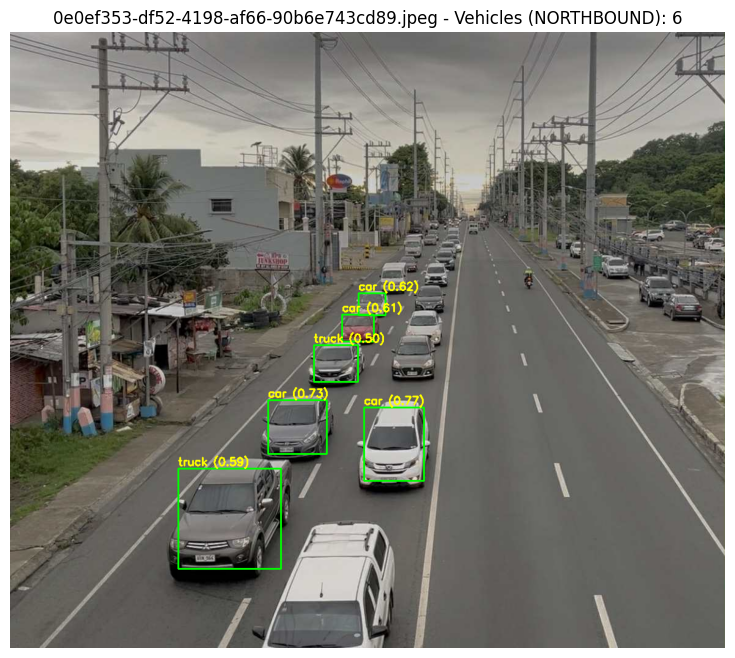

📊 Vehicle breakdown for 0e0ef353-df52-4198-af66-90b6e743cd89.jpeg:
  Car: 4
  Truck: 2
  Motorcycle: 0
✅ Total vehicles: 6



In [ ]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io
import time

# 🏷️ COCO class labels
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A',
    'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote',
    'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush','tomato'
]

# 📤 Upload image
uploaded = files.upload()
file_name = next(iter(uploaded))
img = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")

# 🔄 Convert to tensor
img_tensor = F.to_tensor(img)

# 🎯 Load pre-trained RetinaNet model
model = retinanet_resnet50_fpn(pretrained=True)
model.eval()

# ⏱️ Run inference
start_time = time.time()
with torch.no_grad():
    pred = model([img_tensor])[0]
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.4f} seconds")

# 📐 Image dimensions
img_width, img_height = img.size
left_limit = img_width * 0.45
right_limit = img_width * 0.55

# 🧮 Vehicle counters
vehicle_counts = {
    "car": 0,
    "truck": 0,
    "motorcycle": 0
}

# 🖼️ Display results
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for i in range(len(pred['boxes'])):
    score = pred['scores'][i].item()
    if score > 0.5:
        label_idx = pred['labels'][i].item()
        label = COCO_INSTANCE_CATEGORY_NAMES[label_idx]

        if label in vehicle_counts:
            box = pred['boxes'][i].numpy()
            x1, y1, x2, y2 = box
            x_center = (x1 + x2) / 2

            if x_center < right_limit:
                vehicle_counts[label] += 1

                # 📦 Shrink the bounding box by 20%
                shrink_factor = 0.2
                box_width = x2 - x1
                box_height = y2 - y1
                cx = (x1 + x2) / 2
                cy = (y1 + y2) / 2

                new_width = box_width * (1 - shrink_factor)
                new_height = box_height * (1 - shrink_factor)
                x1 = cx - new_width / 2
                x2 = cx + new_width / 2
                y1 = cy - new_height / 2
                y2 = cy + new_height / 2

                ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                               linewidth=2, edgecolor='yellow', facecolor='none'))
                ax.text(x1, y1, f"{label}: {score:.2f}", fontsize=10,
                        bbox=dict(facecolor='red', alpha=0.5))

# 🧾 Summary
total_detected = sum(vehicle_counts.values())
title_str = f"Vehicles(NORTHBOUND): {total_detected} | Inference: {inference_time:.2f}s"
plt.title(title_str)
plt.axis('off')
plt.show()

# 📊 Print breakdown
print("Vehicle breakdown (NORTHBOUND):")
for vehicle, count in vehicle_counts.items():
    print(f"{vehicle.title()}: {count}")
print(f"Total vehicles: {total_detected}")


In [ ]:
import torch
import os
import io
import time
from torchvision.models.detection import retinanet_resnet50_fpn
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files

# 📤 Upload image
uploaded = files.upload()
file_name = next(iter(uploaded))
img = Image.open(io.BytesIO(uploaded[file_name])).convert("RGB")
img_tensor = F.to_tensor(img)

# 📦 Load RetinaNet model
model = retinanet_resnet50_fpn(pretrained=True)
model.eval()

# 💾 Calculate model size
torch.save(model.state_dict(), "retinanet_weights.pth")
model_size_mb = os.path.getsize("retinanet_weights.pth") / (1024 * 1024)

# ⏱ Inference
start_time = time.time()
with torch.no_grad():
    pred = model([img_tensor])[0]
inference_time = time.time() - start_time

# ✅ Sample ground truth boxes (format: [x1, y1, x2, y2]) — replace with real annotations
ground_truth_boxes = [
    [50, 60, 200, 210],   # Example box for a car
    [300, 100, 450, 250]  # Example box for a truck
]

# 📐 IoU function
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    inter_area = max(0, xB - xA) * max(0, yB - yA)
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union_area = areaA + areaB - inter_area
    return 0.0 if union_area == 0 else inter_area / union_area

# 🔍 Compute IoUs
ious = []
for i in range(len(pred['boxes'])):
    score = pred['scores'][i].item()
    if score > 0.5:
        pred_box = pred['boxes'][i].tolist()
        for gt_box in ground_truth_boxes:
            iou = compute_iou(pred_box, gt_box)
            ious.append((pred_box, gt_box, round(iou, 4)))

# 🖼️ Display
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img)

for box in ground_truth_boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=2, edgecolor='green', facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1]-10, "GT", color='green', fontsize=12)

for i in range(len(pred['boxes'])):
    score = pred['scores'][i].item()
    if score > 0.5:
        box = pred['boxes'][i].tolist()
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1]-10, f"{score:.2f}", color='red', fontsize=12)

plt.axis('off')
plt.title(f"RetinaNet Inference Time: {inference_time:.2f}s | Model Size: {model_size_mb:.2f} MB")
plt.show()

# 📊 Output
print(f"🕒 Inference Time: {inference_time:.4f} seconds")
print(f"📦 Model Size: {model_size_mb:.2f} MB")
print("📈 IoU Results:")
for p, g, iou in ious:
    print(f"Predicted: {p}, Ground Truth: {g}, IoU: {iou}")


In [ ]:
!pip install torch torchvision --quiet
!pip install ultralytics --quiet

import torch
import time
from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    retinanet_resnet50_fpn
)
from torchvision.transforms import functional as F
from PIL import Image
from ultralytics import YOLO

# Upload image
from google.colab import files
uploaded = files.upload()
file_name = next(iter(uploaded))
img = Image.open(file_name).convert("RGB")
img_tensor = F.to_tensor(img)

# Measure inference time for torchvision models
def measure_torchvision_model(model_fn, tensor):
    model = model_fn(pretrained=True)
    model.eval()
    with torch.no_grad():
        start = time.time()
        _ = model([tensor])
        end = time.time()
    return end - start

# Measure inference time for YOLOv5
def measure_yolo(image_path):
    model = YOLO("yolov5s.pt")
    start = time.time()
    _ = model.predict(image_path, save=False, verbose=False)
    end = time.time()
    return end - start

# Run measurements
faster_time = measure_torchvision_model(fasterrcnn_resnet50_fpn, img_tensor)
retina_time = measure_torchvision_model(retinanet_resnet50_fpn, img_tensor)
yolo_time = measure_yolo(file_name)

# Print results
print(f"Faster R-CNN Inference Time: {faster_time:.4f} seconds")
print(f"RetinaNet Inference Time: {retina_time:.4f} seconds")
print(f"YOLOv5 Inference Time: {yolo_time:.4f} seconds")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

Saving 1c847388-0949-483e-9130-e95c985c8b5c.jpeg to 1c847388-0949-483e-9130-e95c985c8b5c.jpeg


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 88.2MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `Non

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 17.7M/17.7M [00:00<00:00, 196MB/s]


Faster R-CNN Inference Time: 8.2281 seconds
RetinaNet Inference Time: 6.6495 seconds
YOLOv5 Inference Time: 1.1995 seconds


In [ ]:
pip install roboflow

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving b1536fa2-4bfe-49a9-8047-c3b771da6f89.mp4 to b1536fa2-4bfe-49a9-8047-c3b771da6f89.mp4


In [ ]:
video_path = list(uploaded.keys())[0]  # Should be "haha.mp4" if that's what you uploaded


In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="rHi5H8Ymqly0hD1aAKXe")
project = rf.workspace().project("ph-vehicles-ajvkf")
model = project.version("1").model

job_id, signed_url, expire_time = model.predict_video(
    video_path,
    fps=5,
    prediction_type="batch-video",
)

results = model.poll_until_video_results(job_id)

print(results)


loading Roboflow workspace...
loading Roboflow project...
Checking for video inference results for job eddd5019-e7ce-48b5-8ab5-1db70d799268 every 60s
(0s): Checking for inference results
(60s): Checking for inference results
(120s): Checking for inference results
(180s): Checking for inference results
{'frame_offset': [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228, 234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306, 312, 318], 'time_offset': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6], 'ph-vehicles-ajvkf': [{'inference_id': '681d0825-81ae-4950-b9d6-6100a9932409', 'time': 0.12174995290115476, 'image': {'width': 648, 'hei